In [104]:
from scipy.io import wavfile
from scipy.fftpack import rfft, irfft
from scipy.signal import find_peaks
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np
import scipy
import aubio
from collections import defaultdict
from scipy.signal import butter, lfilter, freqz
%matplotlib inline

In [237]:
filename = 'do.wav'
sample_rate, channels = wavfile.read(filename)
window_size = 8192
stride = 512
data_length = channels[:, 0].shape[0]
data = (channels[:, 0] + channels[:, 1]) / 2  # todo: that's going to change
amplitude = max(max(data), -min(data))
data = list(map(lambda x: x / amplitude, data))

left = sample_rate*10
right = sample_rate*40

In [238]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def FILTERBLYAT(data, cutoff):
    # Filter requirements.
    order = 6

    # Filter the data, and plot both the original and filtered signals.
    y = butter_lowpass_filter(data, cutoff, sample_rate, order)
    return y

In [239]:
def CountEnergy(musik, sample=1024):
    E = []
    curE = 0
    for i in range(sample):
        curE += musik[i] ** 2
    for i in range(0, len(musik) - sample):
        curE += musik[i + sample] ** 2
        curE -= musik[i] ** 2
        E.append(curE)
    return E

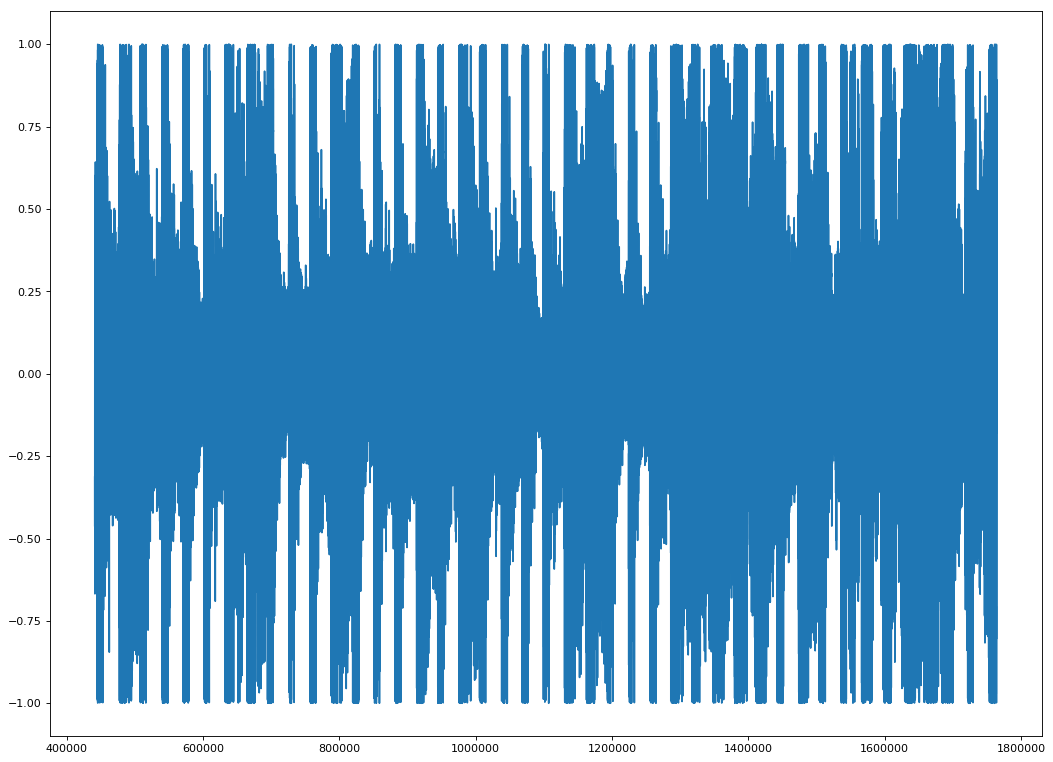

In [240]:
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(left, right), data[left:right])
plt.show()

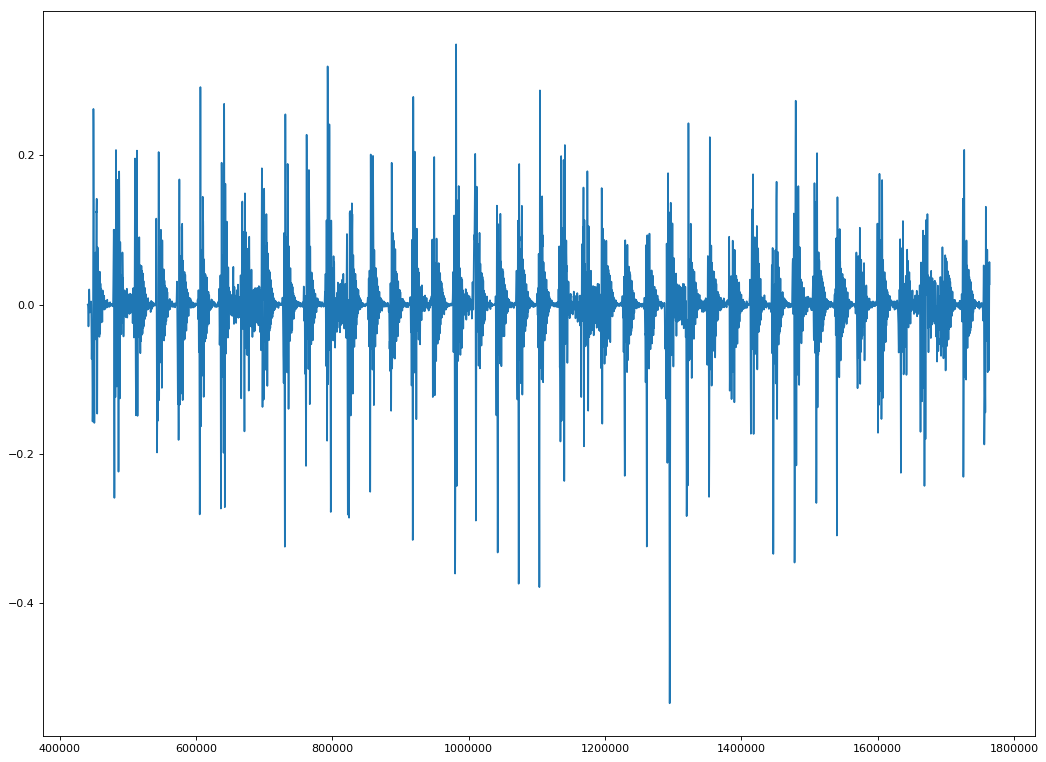

In [241]:
filtered = FILTERBLYAT(data[left:right], 30)
SAMPLEBL = 1024
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(left, right), filtered)
plt.show()

In [242]:
E = CountEnergy(filtered, SAMPLEBL)

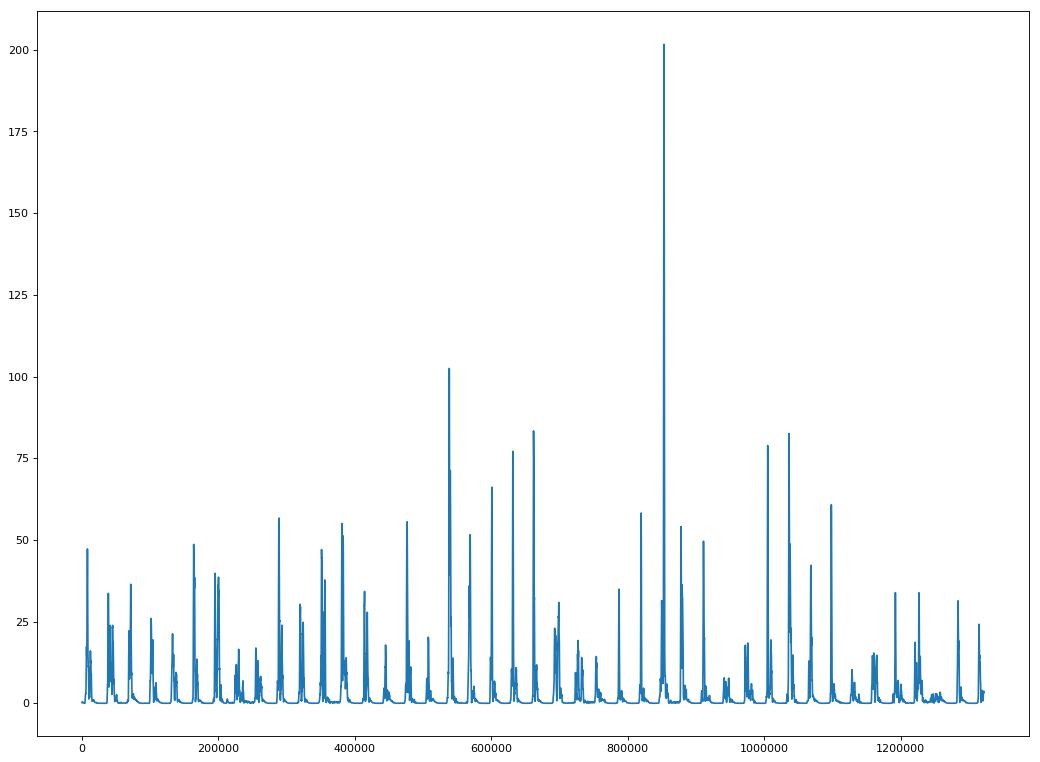

In [243]:
Elin = np.array(E)

figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Elin)
plt.show()

In [244]:
def MAXWINDOW(arr, sample, threshold):
    stack = []
    res = []
    for i in range(0, sample):
        while len(stack) > 0 and arr[stack[-1]] < arr[i + sample]:
            stack.pop()
        stack.append(i)
    for i in range(0, len(arr) - sample):
        while len(stack) > 0 and arr[stack[-1]] < arr[i + sample]:
            stack.pop()
        stack.append(i + sample)
        value = stack[0]
        if arr[value] < threshold:
            value = 0
        res.append(arr[value])
        if stack[0] == i:
            stack.pop(0)
    return res

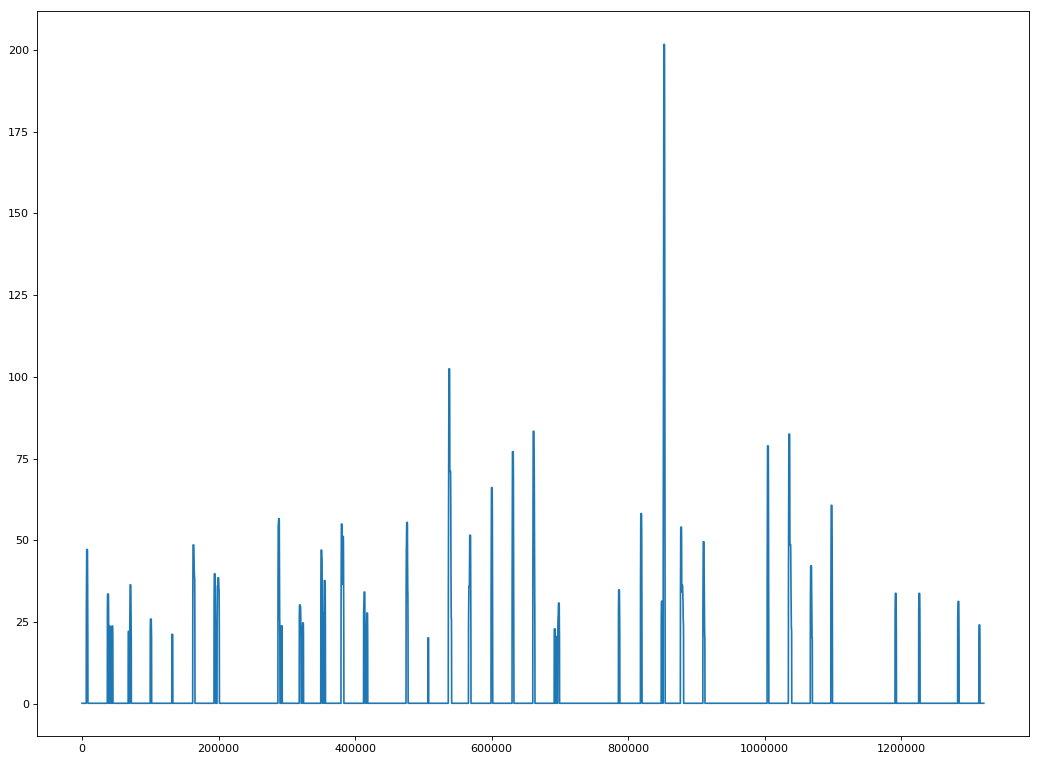

In [245]:
mxw = MAXWINDOW(Elin, SAMPLEBL, 20)
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
#mxw = Elin[mxw]
mxwlr = mxw
plt.plot(mxwlr)
plt.show()

In [246]:
def FINDPEAKS(arr, step, thres):
    i = 0
    peaks = []
    while (i < len(arr)):
        if arr[i] > thres:
            peaks.append(i)
            i += step
        i += 1
    return peaks

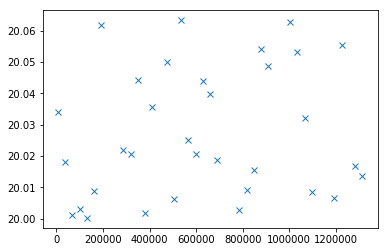

In [247]:
peaks = FINDPEAKS(mxw, sample_rate//5, 20)
#print(peaks)
peaksev = list(map(lambda x: mxw[x], peaks))
plt.plot(peaks, peaksev, "x")

In [248]:
def CNTBPM(peaks):
    bpms = []
    for i in range(60, 180):
        bpms.append(60 * sample_rate / i)

    cnt = dict()
    for i in range(len(bpms)):
        cnt[bpms[i]] = 0
    
    for i in range(len(peaks) - 1):
        a = peaks[i]
        b = peaks[i + 1]
        val = (b - a)
        while val > bpms[0]:
            val /= 2
        while val < bpms[-1]:
            val *= 2
        cbpm = 0
        for j in range(len(bpms)):
            if abs(bpms[cbpm] - val) > abs(bpms[j] - val):
                cbpm = j
                
        cnt[bpms[cbpm]] += 1
    
    srt = []
    for k, v in cnt.items():
        srt.append([v, k])
    
    srt.sort(reverse=True)
    avg = 0
    cnt = 0
    for i in range(len(srt)):
        if srt[i][0] == srt[0][0]:
            avg += srt[i][1]
            cnt += 1
    return round(60 * sample_rate / (avg / cnt))

In [249]:
print(CNTBPM(peaks))

85
